In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_PATH_BSE = "/content/drive/MyDrive/geohackathon/Images/BSE/Image15_40.tif"
IMAGE_PATH_CL = "/content/drive/MyDrive/geohackathon/Images/CL/Image15_40.tif"


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
image_bse = cv2.imread(IMAGE_PATH_BSE)

# Image Filtering

We will use 2D-convolution kernels and the OpenCV library to apply different blurring and sharpening techniques to an image.

In image processing, a convolution kernel is a 2D matrix that is used to filter images. Also known as a convolution matrix, a convolution kernel is typically a square, MxN matrix, where both M and N are odd integers (e.g. 3×3, 5×5, 7×7 etc.). 

Such kernels can be used to perform mathematical operations on each pixel of an image to achieve a desired effect (like blurring or sharpening an image). But why would you want to blur an image? Here are two important reasons:

- Because it reduces certain types of noise in an image. For this reason, blurring is often referred to as smoothing.
- To remove a distracting background, you might intentionally blur portions of an image, as is done in ‘Portrait’ mode, on mobile device cameras.

How it works?
- Assume that the center of the kernel is positioned over a specific pixel (p), in an image.
- Then multiply the value of each element in the kernel (1 in this case), with the corresponding pixel element (i.e. its pixel intensity) in the source image.
- Now, sum the result of those multiplications and compute the average.
- Finally, replace the value of pixel (p), with the average value you just computed.

kernel shape: (3, 3)


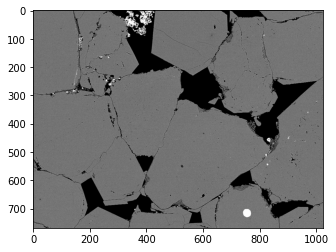

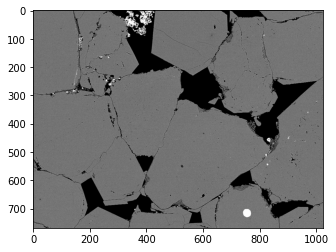

In [ ]:
kernel1 = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])

print(f"kernel shape: {kernel1.shape}")
# filter2D() function can be used to apply kernel to an image.
# Where ddepth is the desired depth of final image. ddepth is -1 if...
# ... depth is same as original or source image.
identity = cv2.filter2D(src=image_bse, ddepth=-1, kernel=kernel1)

plt.imshow(image_bse)
plt.show()
plt.imshow(identity)
plt.show()

kernel shape: (5, 5)


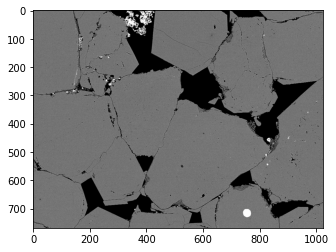

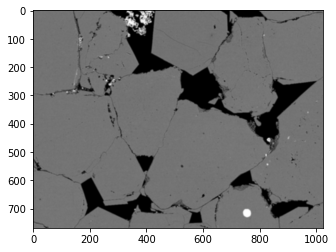

In [ ]:
kernel2 = np.ones((5, 5), np.float32) / 25

print(f"kernel shape: {kernel2.shape}")
# filter2D() function can be used to apply kernel to an image.
# Where ddepth is the desired depth of final image. ddepth is -1 if...
# ... depth is same as original or source image.
blur = cv2.filter2D(src=image_bse, ddepth=-1, kernel=kernel2)

plt.imshow(image_bse)
plt.show()
plt.imshow(blur)
plt.show()

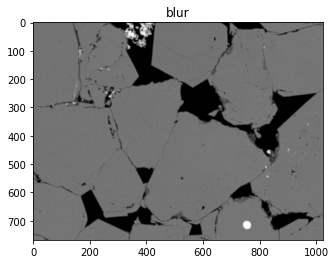

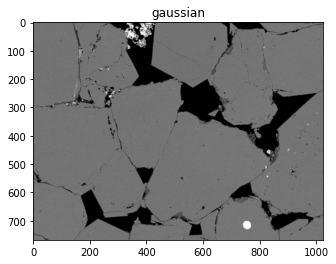

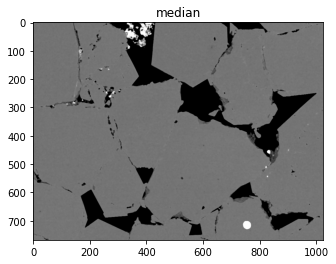

In [ ]:
# use built-in opencv functions
## blur
blur = cv2.blur(src=image_bse, ksize=(5,5))
plt.imshow(blur)
plt.title("blur")
plt.show()

## Gaussian blur
### This technique uses a Gaussian filter, which performs a weighted average
### the Gaussian blur weights pixel values, based on their distance from the center of the kernel. Pixels further from the center have less influence on the weighted average.
### Gaussian kernel standard deviations, in the X (horizontal) and Y (vertical) direction.
gaussian_blur = cv2.GaussianBlur(src=image_bse, ksize=(5,5), sigmaX=0, sigmaY=0)
plt.imshow(gaussian_blur)
plt.title("gaussian")
plt.show()

## Median Blur: each pixel in the source image is replaced by the median value of the image pixels in the kernel area

median_blur = cv2.medianBlur(src=image_bse, ksize=5)
plt.imshow(median_blur)
plt.title("median")
plt.show()

While blurring can be an effective way to reduce noise in an image, it is often not desirable to blur the entire image, as important details and sharp edges may be lost. In such cases, bilateral filtering can make your life easier.

- This technique applies the filter selectively to blur similar intensity pixels in a neighborhood. Sharp edges are preserved, wherever possible.
- It lets you control not only the spatial size of the filter, but also the degree to which the neighboring pixels are included in the filtered output. This is done, based on variation in their color intensity, and also distance from the filtered pixel.

Bilateral filtering essentially applies a 2D Gaussian (weighted) blur to the image, while also considering the variation in intensities of neighboring pixels to minimize the blurring near edges (which we wish to preserve). What this means is that the shape of the kernel actually depends on the local image content, at every pixel location.

Assume, you are filtering a region in an image, near an edge. A simple Gaussian blur filter would blur the edge because it lies near the filtered region (close to the center of the Gaussian filter).  But the bilateral filter can sense the edge, because it also considers differences in pixel intensities. So, it will compute a much lower weight for the pixels straddling the edge, thereby reducing their influence on the filtered region. Regions of more uniform intensity are blurred heavier, as they are not associated with strong edges.

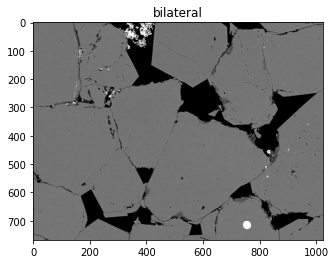

In [ ]:
# Using the function bilateralFilter() where d is diameter of each...
# ...pixel neighborhood that is used during filtering.
# sigmaColor is used to filter sigma in the color space.
# sigmaSpace is used to filter sigma in the coordinate space.
bilateral_filter = cv2.bilateralFilter(src=image_bse, d=9, sigmaColor=75, sigmaSpace=75)
plt.imshow(bilateral_filter)
plt.title("bilateral")
plt.show()

# Image Registration / Alignment

In [ ]:
def registration(IMAGE_PATH_BSE, IMAGE_PATH_CL):
    # Read the images to be aligned
    im1 =  cv2.imread(IMAGE_PATH_BSE)
    im2 =  cv2.imread(IMAGE_PATH_CL)

    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

    # # Show final results
    # plt.imshow(im1)
    # plt.show()
    # # plt.imshow(im2)
    # # plt.show()
    # plt.imshow(im2_aligned)
    # plt.show()
    return im1, im2, im2_aligned

In [ ]:
# for ...

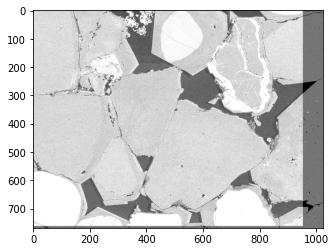

In [ ]:
im1, im2, im2_aligned = registration(IMAGE_PATH_BSE, IMAGE_PATH_CL)
plt.imshow(cv2.add(im2_aligned, im1))
plt.show()

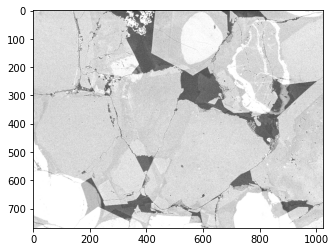

In [ ]:
plt.imshow(cv2.add(im2, im1))
plt.show()